In [1]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt

In [2]:
#loss=data-theory, define covariance function, chi^2=loss@cov^-1@loss (@ is shortcut for dot product), cov=NxN mtx, N=# of points, for now, use identity mtx, fit in range between 2 Mpc-8 Mpc scipy.minimize, fix pk, vary bg, calc pk only once bc slow, read about chi^2 fitting 
#meeting Friday, plan to finish pipeline, get chi^2 set up, 1pm

In [3]:
#requires mcfit, pip install mcfit
# see https://arxiv.org/pdf/0911.4973.pdf... eq. 47-50
# for IA beta, see https://arxiv.org/pdf/1510.06752.pdf
import mcfit
from mcfit import P2xi
from scipy.interpolate import interp1d
from scipy.special import eval_legendre as legendre
from scipy import integrate
import numpy as np

class Projected_Corr_RSD():
    def __init__(self,rp=None,pi=None,pi_max=100,l=[0,2,4],k=None):
        self.rp=rp
        self.pi=pi
        if rp is None:
            self.rp=np.logspace(-1,np.log10(200),100)
        if pi is None:
            self.pi=np.logspace(-3,np.log10(pi_max),250)
#            self.pi=np.append(0,self.pi)
        self.dpi=np.gradient(self.pi)
        self.piG,self.rpG=np.meshgrid(self.pi,self.rp)
        self.rG=np.sqrt(self.rpG**2+self.piG**2)
        self.muG=self.piG/self.rG
        self.L={}
        self.j={}
        for i in l:
            self.L[i]=legendre(i,self.muG)
            self.j[i]=P2xi(k,l=i)
        
    def alpha(self,l,beta1,beta2):
        if l==0:
            return 1+1./3.*(beta1+beta2)+1./5*(beta1*beta2)
        elif l==2:
            return 2./3.*(beta1+beta2)+4./7.*(beta1*beta2)
        elif l==4:
            return 8./35.*(beta1*beta2)
#wgm to wg+
    def w_to_DS(self,rp=[],w=[]):
        DS0=2*w[0]*rp[0]**2
        return 2.*integrate.cumtrapz(w*rp,x=rp,initial=0)/rp**2-w+DS0/rp**2

    def get_xi(self,pk=[],l=[0,2,4]):
        xi={}
        for i in l:
            ri, xi_i = self.j[i](pk)
            xi_intp=interp1d(ri,xi_i,bounds_error=False,fill_value=0)
            xi[i]=(xi_intp(self.rG)*self.L[i])@self.dpi
            xi[i]*=2#one sided pi
        return xi

    def wgg_calc(self,f=0,bg=0,bg2=None,pk=[],xi=None,l=[0,2,4]):
        bg1=bg
        if bg2 is None:
            bg2=bg
        beta1=f/bg1
        beta2=f/bg2
        if xi is None:
            xi=self.get_xi(pk=pk,l=l)
        W=np.zeros_like(xi[0])
        for i in l:
            W+=(xi[i].T*self.alpha(i,beta1,beta2)*bg1*bg2).T
        return W

    #do_DS calls w_to_DS to convert wgm to wg+, set beta2=-1 for wg+
    def wgm_calc(self,f=0,bg=0,beta2=0,pk=[],xi=None,l=[0,2,4],do_DS=False):
        beta1=f/bg
        if xi is None:
            xi=self.get_xi(pk=pk,l=l)
        W=np.zeros_like(xi[0])
        for i in l:
            W+=(xi[i].T*self.alpha(i,beta1,beta2)*bg).T
        if do_DS:
            W=self.w_to_DS(rp=self.rp,w=W)
        return W

In [4]:
#import camb
#from camb import model, initialpower

#import pyccl
from classy import Class
import numpy as np
from scipy.interpolate import interp1d
from astropy.cosmology import Planck15 as cosmo
from astropy.constants import c,G
from astropy import units as u
from scipy.integrate import quad as scipy_int1d

cosmo_h=cosmo.clone(H0=100)
c=c.to(u.km/u.second)

cosmo_fid=dict({'h':cosmo.h,'Omb':cosmo.Ob0,'Omd':cosmo.Om0-cosmo.Ob0,'s8':0.817,'Om':cosmo.Om0,
                'As':2.12e-09,'mnu':cosmo.m_nu[-1].value,'Omk':cosmo.Ok0,'tau':0.06,'ns':0.965,'w':-1,'wa':0})
pk_params={'non_linear':1,'kmax':30,'kmin':3.e-4,'nk':5000}
class_accuracy_settings={ #from Vanessa. To avoid class errors due to compiler issues.
                          #https://github.com/lesgourg/class_public/issues/193
            "k_min_tau0":0.002, #you could try change this
            "k_max_tau0_over_l_max":3., #you can also try 5 here
            "k_step_sub":0.015,
            "k_step_super":0.0001,
            "k_step_super_reduction":0.1,
            'k_per_decade_for_pk': 20,
#             'k_output_values': 2.0,
            'perturb_sampling_stepsize':0.01,
            'tol_perturb_integration':1.e-4,
            'halofit_k_per_decade': 3000. #you could try change this
            }
class Power_Spectra():
    def __init__(self,cosmo_params=cosmo_fid,pk_params=pk_params,cosmo=cosmo,cosmo_h=None):
        self.cosmo_params=cosmo_params
        self.pk_params=pk_params
        self.cosmo=cosmo

        if not cosmo_h:
            self.cosmo_h=cosmo.clone(H0=100)
        else:
            self.cosmo_h=cosmo_h
            
        if not pk_params is None:
            self.kh=np.logspace(np.log10(pk_params['kmin']),np.log10(pk_params['kmax']),
            pk_params['nk'])

    def Rho_crit(self,cosmo_h=None):
        if not cosmo_h:
            cosmo_h=self.cosmo_h
        G2=G.to(u.Mpc/u.Msun*u.km**2/u.second**2)
        rc=3*cosmo_h.H0**2/(8*np.pi*G2)
        rc=rc.to(u.Msun/u.pc**2/u.Mpc)# unit of Msun/pc^2/mpc
        return rc

    def DZ_int(self,z=[0],cosmo=None): #linear growth factor.. full integral.. eq 63 in Lahav and suto
        if not cosmo:
            cosmo=self.cosmo
        def intf(z):
            return (1+z)/(cosmo.H(z).value)**3
        j=0
        Dz=np.zeros_like(z,dtype='float32')
        
        for i in z:
            Dz[j]=cosmo.H(i).value*scipy_int1d(intf,i,np.inf,epsrel=1.e-6,epsabs=1.e-6)[0]
            j=j+1
        Dz*=(2.5*cosmo.Om0*cosmo.H0.value**2)
        return Dz/Dz[0]
    
    def class_pk(self,z,cosmo_params=None,pk_params=None,return_s8=False):
        if  cosmo_params is None:
            cosmo_params=self.cosmo_params
        if pk_params is None:
            pk_params=self.pk_params
            
        cosmoC=Class()
        h=cosmo_params['h']
        class_params={'h':h,'omega_b':cosmo_params['Omb']*h**2,
                            'omega_cdm':(cosmo_params['Om']-cosmo_params['Omb'])*h**2,
                            'A_s':cosmo_params['As'],'n_s':cosmo_params['ns'],
                            'output': 'mPk','z_max_pk':100, #max(z)*2, #to avoid class error.
                                      #Allegedly a compiler error, whatever that means
                            'P_k_max_1/Mpc':pk_params['kmax']*h*1.1,
                    }
        if pk_params['non_linear']==1:
            class_params['non linear']='halofit'

        class_params['N_ur']=3.04 #ultra relativistic species... neutrinos
        if cosmo_params['mnu']!=0:
            class_params['N_ur']-=1 #one massive neutrino
            class_params['m_ncdm']=cosmo_params['mnu']
        class_params['N_ncdm']=3.04-class_params['N_ur']
        if cosmo_params['w']!=-1 or cosmo_params['wa']!=0:
            class_params['Omega_fld']=cosmo_params['Oml']
            class_params['w0_fld']=cosmo_params['w']
            class_params['wa_fld']=cosmo_params['wa']

        for ke in class_accuracy_settings.keys():
            class_params[ke]=class_accuracy_settings[ke]

        cosmoC=Class()
        cosmoC.set(class_params)
        try:
            cosmoC.compute()
        except Exception as err:
            print(class_params, err)
            raise Exception('Class crashed')

        k=self.kh*h
        pkC=np.array([[cosmoC.pk(ki,zj) for ki in k ]for zj in z])
        pkC*=h**3
        s8=cosmoC.sigma8()
        cosmoC.struct_cleanup()
        if return_s8:
            return pkC,self.kh,s8
        else:
            return pkC,self.kh

In [5]:
PS=Power_Spectra()
pk,k=PS.class_pk(z=np.atleast_1d([0.0625]))
#wrong power spectrum, get from Class
rp=np.logspace(-1,1,21)[:20]
d=Projected_Corr_RSD(rp=rp,pi=np.linspace(0,50,10),k=k)
wgg=d.wgg_calc(bg=1,pk=pk)
data=np.loadtxt('/global/homes/h/hmarti21/Results/Final_Results/BGG_massbin1/DelGG_85Result.txt')
number=len(wgg[0])

In [15]:
d=Projected_Corr_RSD(rp=rp,pi=np.linspace(0,50,5),k=k)
def fn_to_min(bg,data,rp,pk,k,randomcount):
    x=rp>3
    x*=rp<5
    wgg=d.wgg_calc(bg=bg,pk=pk)
    #print(bg)
    if bg<0:
        return np.inf
    return chi_sq(wgg[0][x],data[x],rp[x],randomcount[x])

In [16]:
def chi_sq(model,data,rp,randomcount):
    loss=data-model
    #print(loss)
    cov=np.diag(1./randomcount)
    cov_inv=np.linalg.inv(cov)
    chi_sq=loss@cov_inv@loss
    return chi_sq*0.5
    

In [68]:
randomcount=np.loadtxt('/global/homes/h/hmarti21/Results/Final_Results/BGG_massbin1/DelGG_85normRRCount.txt')
randomcountsum=np.sum(randomcount,axis=0)
minimum=minimize(fn_to_min,np.array(1),args=(data,rp,pk,k,randomcountsum/100))


In [69]:
minimum.x

array([0.5116551])

In [70]:
minimum.hess_inv

array([[26.2922145]])

In [71]:
minimum.values()

dict_values([9.884936224989287e-06, array([7.43167493e-06]), array([[26.2922145]]), 24, 8, 0, True, 'Optimization terminated successfully.', array([0.5116551]), 7])

In [72]:
minimum.success

True

In [ ]:
1./randomcountsum

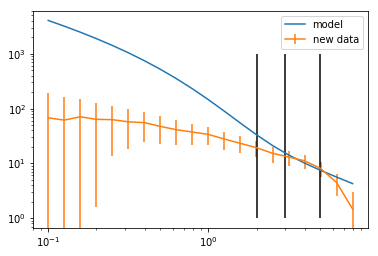

In [73]:
wgg=d.wgg_calc(bg=minimum.x[0],pk=pk)
plt.plot(rp[:20],wgg[0],label='model')
plt.errorbar(rp[:20],data,np.sqrt(1./randomcountsum/100),label='new data')
plt.vlines(2,1,1000)
plt.vlines(5,1,1000)
plt.vlines(3,1,1000)
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [10]:
GG_bin1=np.loadtxt('/global/homes/h/hmarti21/Results/Final_Results/BGG_massbin1/DelGG_85Result.txt')
GG_bin2=np.loadtxt('/global/homes/h/hmarti21/Results/Final_Results/BGG_massbin2/DelGG_85Result.txt')
GG_bin3=np.loadtxt('/global/homes/h/hmarti21/Results/Final_Results/BGG_massbin3/DelGG_85Result.txt')


In [11]:
minimum_bin1=minimize(fn_to_min,np.array(1),args=(GG_bin1,rp,pk,k))
minimum_bin2=minimize(fn_to_min,np.array(1),args=(GG_bin2,rp,pk,k))
minimum_bin3=minimize(fn_to_min,np.array(1),args=(GG_bin3,rp,pk,k))


In [14]:
print(minimum_bin1.x, minimum_bin2.x, minimum_bin3.x)


[0.50877311] [0.60648136] [1.1241888]


In [62]:
1./randomcountsum

array([1.53435009e+06, 9.60805775e+05, 6.09043403e+05, 3.84593269e+05,
       2.43228074e+05, 1.53526043e+05, 9.71761850e+04, 6.13181410e+04,
       3.87140369e+04, 2.44864842e+04, 1.55162480e+04, 9.80203605e+03,
       6.20725394e+03, 3.92771661e+03, 2.48647368e+03, 1.57126761e+03,
       9.90558558e+02, 6.22317218e+02, 3.90212112e+02, 2.44648449e+02])

In [74]:
MM_comb=np.loadtxt('/global/homes/h/hmarti21/Results/Final_Results/BMM_1/DelMM_85combineResult.txt')

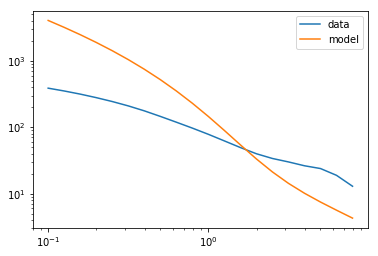

In [76]:
plt.plot(rp[:20],MM_comb,label='data')
plt.plot(rp[:20],wgg[0],label='model')
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [78]:
#Dark Matter only simulation to compare with model - Sukhdeep needs to get access to it